# Variance-level plots

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinAnalysis import *

In [6]:
ls = [6, 7, 8, 9, 10]

In [7]:
data_args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    data_args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        } )

In [8]:
source_path = "/home/florianb/havvarsel/multilevelDA/scripts/VarianceLevelsDA/Basin/2023-05-28T17_34_43depK"

In [9]:
import matplotlib.lines as mlines

def plotLvlVarTs(source_path, relative=False, center=False):

    if center:
        centerstart="center_"
    else:
        centerstart=""

    # Read files
    vars_list = []
    diff_vars_list = []
    for f in os.listdir(source_path):
        if f.startswith(centerstart+"diff_vars"):
            diff_vars_list.append( os.path.abspath(os.path.join(source_path, f)) )
        if f.startswith(centerstart+"vars"):
            vars_list.append( os.path.abspath(os.path.join(source_path, f)) ) 

    # Sort files 
    if center:
        vars_list = [f for _,f in sorted(zip([int(v.split("/")[-1].split("_")[2].split(".")[0]) for v in vars_list], vars_list)) ]
        diff_vars_list = [f for _,f in sorted(zip([int(v.split("/")[-1].split("_")[3].split(".")[0]) for v in diff_vars_list], diff_vars_list)) ]
    else:
        vars_list = [f for _,f in sorted(zip([int(v.split("/")[-1].split("_")[1].split(".")[0]) for v in vars_list], vars_list)) ]
        diff_vars_list = [f for _,f in sorted(zip([int(v.split("/")[-1].split("_")[2].split(".")[0]) for v in diff_vars_list], diff_vars_list)) ]

    # Plot
    with plt.rc_context({'lines.color':'black', 
                    'text.color':'black', 
                    'axes.labelcolor':'black', 
                    'xtick.color':'black',
                    'ytick.color':'black'}):
        fig, axs = plt.subplots(1,3, figsize=(15,5))
        if center:
            fig.suptitle("Variance level plot for center")
        else:
            fig.suptitle("Variance level plot")

        axs[0].set_title("$\eta$", fontsize=15)
        axs[1].set_title("$hu$", fontsize=15)
        axs[2].set_title("$hv$", fontsize=15)

        Nxs = [nx*ny for nx, ny in zip([da["nx"] for da in data_args_list], [da["ny"] for da in data_args_list])]

        for T_idx in range(len(vars_list)):
            vars = np.load(vars_list[T_idx])
            diff_vars = np.load(diff_vars_list[T_idx])

            if relative:
                diff_vars = diff_vars/vars[-1]
                vars = vars/vars[-1]
                axs[0].set_ylim((None,2))
                axs[1].set_ylim((None,2))
                axs[2].set_ylim((None,2))

            for i in range(3):

                if T_idx+1 < len(vars_list):
                    axs[i].loglog(Nxs, vars[:,i], linewidth=3, c="C0", alpha=0.1+0.9*T_idx/len(vars_list))
                    axs[i].loglog(Nxs[1:], diff_vars[:,i], linewidth=3, c="C1", alpha=0.1+0.9*T_idx/len(vars_list))
                
                else:
                    axs[i].loglog(Nxs, vars[:,i], linewidth=3, c="C0", ls="--")
                    axs[i].loglog(Nxs[1:], diff_vars[:,i], linewidth=3, c="C1", ls="--")
                    axs[i].set_xlabel("# grid cells", fontsize=15)

                    handles_var = [mlines.Line2D([], [], c="C0", lw=3, label="$|| Var[u^l] ||_{L^2}$"), 
                                   mlines.Line2D([], [], c="C1", lw=3, label="$|| Var[u^l-u^{l-1}] ||_{L^2}$")]
                    legend_var = axs[i].legend(handles=handles_var, labelcolor="black", loc=(0.35,0.01), fontsize=12)
                    axs[i].add_artist(legend_var)

                    axs[i].set_xlabel("# grid cells", fontsize=15)
                    axs[i].set_xticks(Nxs)
                    axs[i].xaxis.grid(True)
                    
                    handles_T = [mlines.Line2D([], [], c="C1", alpha=0.1+0.9*T_idx/len(vars_list), lw=3, label=vars_list[T_idx].split("_")[-1].split(".")[0]) for T_idx in range(len(vars_list)-1)]
                    handles_T.append( mlines.Line2D([], [], c="C1", alpha=0.1+0.9*T_idx/len(vars_list), lw=3, ls="--", label=vars_list[-1].split("_")[-1].split(".")[0]) )
                    axs[i].legend(handles=handles_T, fontsize=12, loc=(0.01,0.01))
        

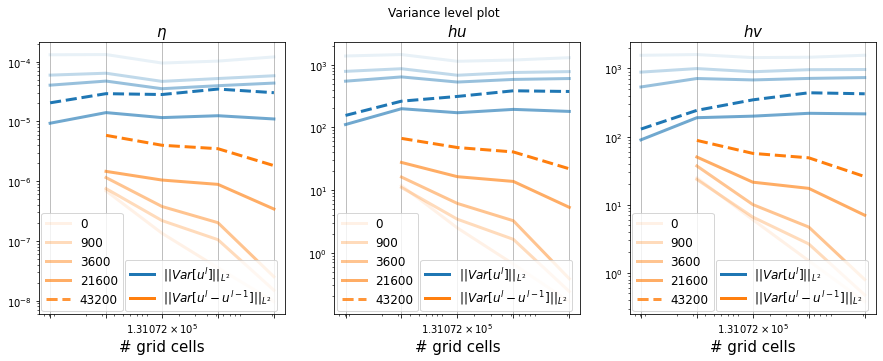

In [10]:
plotLvlVarTs(source_path)

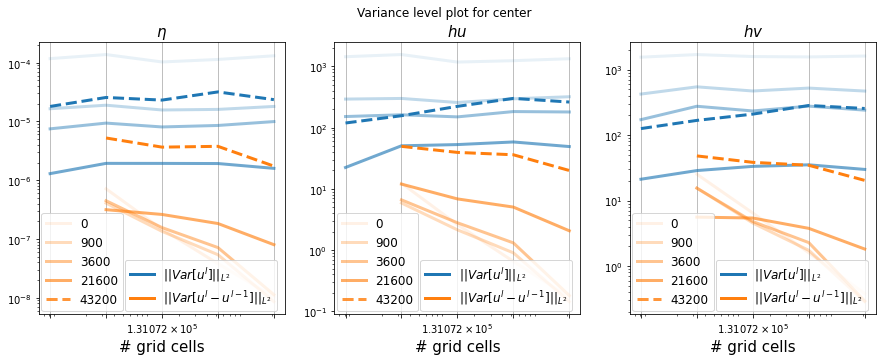

In [11]:
plotLvlVarTs(source_path, center=True)